# **Bitcoin Time Series Prediction : Using Recurrent Neural Network (RNN) and Long Short Term Memory (LSTM)**
## **KARTOBI Sofiane**

## **Import**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly_express as px 
import tensorflow as tf 
from keras.models import Sequential  
from keras.layers import  LSTM ,Dense , SimpleRNN , Dropout , Activation

## Fixing the seed

In [2]:
# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow/Keras
tf.random.set_seed(42)

## **Loading the data**

In [3]:
btc = pd.read_csv('BTC-USD.csv', index_col=0,parse_dates=True)
btc.head(7)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-29,310.914001,320.434998,257.612000,264.195007,264.195007,118523600
2015-01-05,265.084015,298.753998,265.039001,265.660004,265.660004,164241500
2015-01-12,266.145996,272.203003,171.509995,210.339005,210.339005,363112212
2015-01-19,211.470993,255.074005,205.153000,253.718002,253.718002,189165500
2015-01-26,254.078995,309.384003,212.014999,226.972000,226.972000,306840500
2015-02-02,226.490997,245.957001,214.725006,223.412003,223.412003,183691200
2015-02-09,223.389008,265.610992,215.332001,234.824997,234.824997,230343800


In [4]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 471 entries, 2014-12-29 to 2023-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       471 non-null    float64
 1   High       471 non-null    float64
 2   Low        471 non-null    float64
 3   Close      471 non-null    float64
 4   Adj Close  471 non-null    float64
 5   Volume     471 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 25.8 KB


In [5]:
btc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,471.000000,471.000000,471.000000,471.000000,471.000000,4.710000e+02
mean,15029.096060,16085.926142,13983.069238,15118.322049,15118.322049,1.191759e+11
std,16273.001507,17344.768346,15060.866114,16308.015303,16308.015303,1.249700e+11
min,211.470993,231.712997,171.509995,210.339005,210.339005,1.071499e+08
25%,1185.275024,1249.385010,1129.694946,1197.539978,1197.539978,2.542606e+09
50%,8597.308594,9306.405273,7974.819824,8673.215820,8673.215820,9.290509e+10
75%,25883.000000,26791.244141,23829.363281,25954.867188,25954.867188,1.928682e+11
max,65521.289063,68789.625000,62333.914063,65466.839844,65466.839844,7.666798e+11


In [6]:
Closing = btc['Close']
Closing.head(7)

Date
2014-12-29    264.195007
2015-01-05    265.660004
2015-01-12    210.339005
2015-01-19    253.718002
2015-01-26    226.972000
2015-02-02    223.412003
2015-02-09    234.824997
Name: Close, dtype: float64

In [7]:
fig = px.line(btc, x=btc.index, y=Closing, width=900, height=500,title='Bitcoin Closing Price evolution')

fig.show()

In [8]:
print(Closing.shape)
print(type(Closing))

(471,)
<class 'pandas.core.series.Series'>


In [9]:
Closing

Date
2014-12-29      264.195007
2015-01-05      265.660004
2015-01-12      210.339005
2015-01-19      253.718002
2015-01-26      226.972000
                  ...     
2023-12-04    43779.699219
2023-12-11    41364.664063
2023-12-18    43016.117188
2023-12-25    42099.402344
2023-12-31    42189.976563
Name: Close, Length: 471, dtype: float64

## **Preprocessing the data**

In [10]:
from sklearn.preprocessing import MinMaxScaler

## Min Max Scaling data

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(Closing).reshape(-1, 1))

In [12]:
print(scaled_data.shape)
print(type(scaled_data))

(471, 1)
<class 'numpy.ndarray'>


In [13]:
print(np.max(scaled_data))
print(np.min(scaled_data))

1.0000000000000002
0.0


## Spliting Training and Testing data

In [14]:
train_size=int(len(Closing)*0.85)
test_size=len(Closing)-train_size
train,test=scaled_data[0:train_size],scaled_data[train_size:len(Closing)]
print(len(train))
print(len(test))

400
71


In [15]:
len(train) + len(test)

471

## **Preparing the sequences**

In [16]:
def create_dataset(X, y , time_steps = 1) : 
    Xs , ys = [] , []
    for i in range(len(X)-time_steps) :
        v = X[i : (i+time_steps)]
        Xs.append(v)
        ys.append(y[i+ time_steps])
    return np.array(Xs) , np.array(ys)


## **Fixing Parameters**

In [17]:
NO_EPOCHS = 50
BATCH_SIZE = 1
TIME_STEPS = 10

In [18]:

x_train, y_train = create_dataset(train,train,time_steps=TIME_STEPS)
x_test , y_test = create_dataset(test,test,time_steps=TIME_STEPS)

In [19]:
print(x_train.shape , y_train.shape)

(390, 10, 1) (390, 1)


In [20]:
print(x_test.shape , y_test.shape)

(61, 10, 1) (61, 1)


In [21]:
x_train[0].shape

(10, 1)

# **PART 1 : Simple RNN**

## **Building the model**

In [22]:
# Analyse univariée avec RNN : nous avons une seule feature
model1=Sequential()
model1.add(SimpleRNN(50,activation='tanh',return_sequences=True,input_shape=(x_train.shape[1], 1)))
model1.add(SimpleRNN(50,activation='tanh'))
model1.add(Dense(1))
model1.compile(optimizer='adam',loss='mean_squared_error')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 50)            2600      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________


## **Training the model**

In [23]:
# Fitting the RNN to the Training set
history1= model1.fit(x_train, y_train, verbose=1, epochs = NO_EPOCHS,batch_size=BATCH_SIZE, validation_data=(x_test,y_test))

Epoch 1/50
390/390 [==============================] - 7s 10ms/step - loss: 0.0166 - val_loss: 0.0371
Epoch 2/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 3/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0030 - val_loss: 0.0273
Epoch 4/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 5/50
390/390 [==============================] - 4s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 6/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 7/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 8/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0019 - val_loss: 9.0987e-04
Epoch 9/50
390/390 [==============================] - 4s 9ms/step - loss: 0.0020 - val_loss: 9.6314e-04
Epoch 10/50
390/390 [==============================] - 4s 9ms/step - loss: 0.0017 - val_los

## **Ploting the loss**

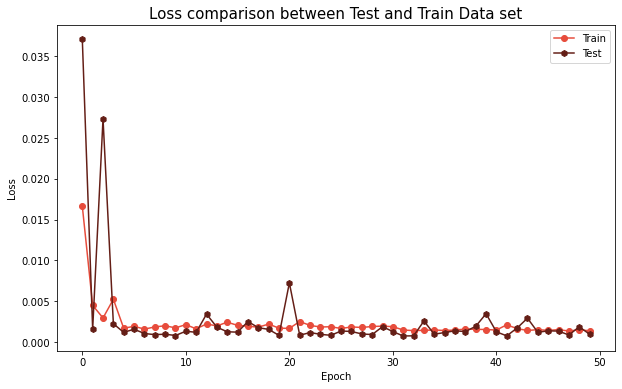

In [24]:
# loss_curve = history1.history["loss"]
# loss_val_curve=history1.history["val_loss"]
# plt.plot(loss_curve, label="Train")
# plt.plot(loss_val_curve, label="Val")
# plt.legend(loc='upper left')
# plt.title("Loss")
# plt.show()

plt.figure(figsize=(10,6))
plt.plot(history1.history['loss'],color="#E74C3C",marker='o')
plt.plot(history1.history['val_loss'],color='#641E16',marker='h')
plt.title('Loss comparison between Test and Train Data set',fontsize=15)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

## **Vizualizing prediction**

In [25]:
train_pred=model1.predict(x_train)
print(len(train_pred))

13/13 [==============================] - 1s 3ms/step
390


In [26]:
test_pred=model1.predict(x_test)
print(len(test_pred))

2/2 [==============================] - 0s 7ms/step
61


In [27]:
# Remettre à l'echelle les variables pour les graphiques
train_pred=scaler.inverse_transform(train_pred)
y_train_rescaled=scaler.inverse_transform(train)
test_pred=scaler.inverse_transform(test_pred)
y_test_rescaled=scaler.inverse_transform(test)

In [28]:
trainScore=model1.evaluate(x_train,y_train,verbose=0)
print(trainScore)
testScore=model1.evaluate(x_test , y_test,verbose=0)
print(testScore)

0.0013932706788182259
0.0009621153003536165


In [29]:
print(len(test_pred))
print(len(y_test_rescaled))


61
71


In [30]:
test_pred_plot=np.empty_like(y_test_rescaled)
test_pred_plot[:]=np.nan
test_pred_plot[TIME_STEPS:]=test_pred

In [31]:
test_pred_plot

array([[           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [20252.20117188],
       [15492.22070312],
       [15666.54785156],
       [15477.8046875 ],
       [15279.7578125 ],
       [15143.94726562],
       [14944.86230469],
       [15662.10839844],
       [15773.42382812],
       [16437.13085938],
       [20453.25      ],
       [22354.25585938],
       [23856.5234375 ],
       [23805.58398438],
       [22908.625     ],
       [25561.9921875 ],
       [23820.421875  ],
       [21958.3203125 ],
       [21670.34179688],
       [27881.61328125],
       [27541.46875   ],
       [28057.11914062],
       [29249.97265625],
       [31343.63671875],
       [28281.95703125],
       [29703.72851562],
       [28443.95507812],
       [26077.65234375],
       [26164.26367188],
       [27211.92773438],


## **Vizualizing predicted test**

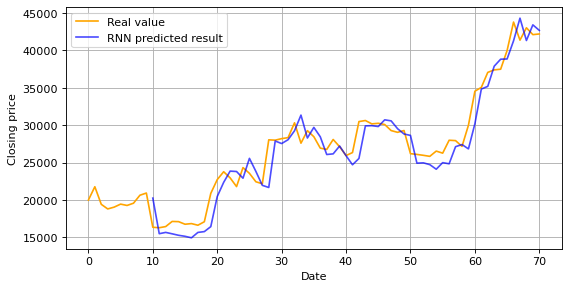

In [32]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_test_rescaled,color="orange",label="Real value")
plt.plot(test_pred_plot,color="blue",alpha=0.7,label="RNN predicted result")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.grid(True)
plt.show()

## **Vizualize predicted train**

In [33]:
train_pred_plot=np.empty_like(y_train_rescaled)
train_pred_plot[:]=np.nan
train_pred_plot[TIME_STEPS:]=train_pred

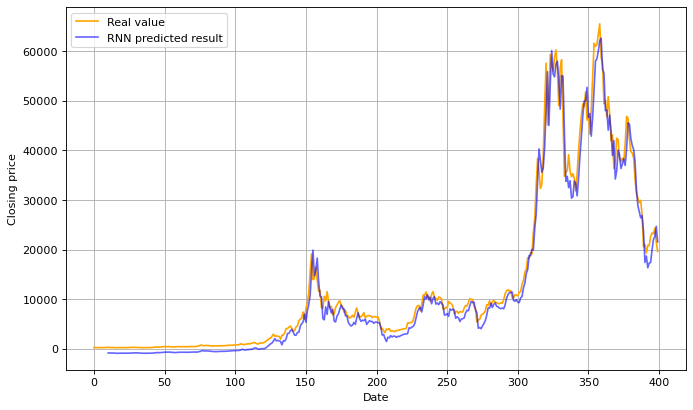

In [34]:
plt.figure(figsize=(10,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_train_rescaled,color="orange",label="Real value")
plt.plot(train_pred_plot,color="blue",alpha=0.6,label="RNN predicted result")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.grid(True)
plt.show()

## **Vizualizing overall predictions**

In [35]:
def plot_predicted_vs_actual(actual_data, train_predicted_data, test_predicted_data):
    # Create a copy of the actual data to avoid modifying the original dataframe
    actual_data_copy = actual_data.copy()

    # Get the datetime index from the actual data
    date_index = actual_data_copy.index

    # Create a new dataframe to hold the predicted values with the datetime index
    train_predicted_df = pd.DataFrame(train_predicted_data, index=date_index[TIME_STEPS:len(date_index)-len(test_predicted_data)-TIME_STEPS])
    
    test_predicted_df = pd.DataFrame(test_predicted_data, index=date_index[len(date_index)-len(test_predicted_data):])
    # Plot actual vs predicted values
    plt.figure(figsize=(10,6), dpi=80, facecolor='w', edgecolor='k') # Adjust the figure size as needed
    plt.plot(actual_data_copy.index, actual_data_copy.values, label='Actual', color='blue')
    plt.plot(train_predicted_df.index, train_predicted_df.values, label='Predicted Train', color='red',alpha=0.7)
    plt.plot(test_predicted_df.index, test_predicted_df.values, label='Predicted Test', color='green',alpha=0.85)

    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title('Actual vs Predicted')
    plt.grid(True)
    plt.legend()
    plt.show()

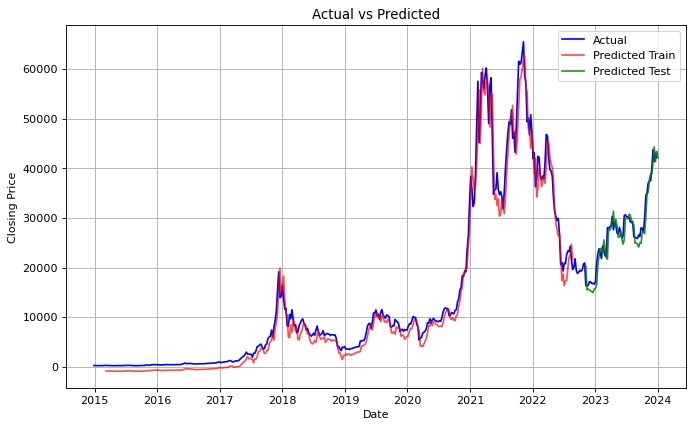

In [36]:
plot_predicted_vs_actual(Closing, train_pred, test_pred)

## **Adding Drop Out**

In [37]:
# Analyse univariée avec RNN : nous avons une seule feature
model2=Sequential()

model2.add(SimpleRNN(50,activation='tanh',return_sequences=True,input_shape=(x_train.shape[1], 1)))
model2.add(Dropout(0.2))

model2.add(SimpleRNN(50,activation='tanh'))
model2.add(Dropout(0.2))

model2.add(Dense(1))
model2.compile(optimizer='adam',loss='mean_squared_error')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 10, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________


## **Re train the model**

In [38]:
# Fitting the RNN to the Training set
history2= model2.fit(x_train, y_train, verbose=1, epochs = NO_EPOCHS,batch_size=BATCH_SIZE, validation_data=(x_test,y_test))

Epoch 1/50
390/390 [==============================] - 8s 10ms/step - loss: 0.0446 - val_loss: 0.0027
Epoch 2/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0168 - val_loss: 0.0073
Epoch 3/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0081 - val_loss: 0.0119
Epoch 4/50
390/390 [==============================] - 3s 7ms/step - loss: 0.0072 - val_loss: 0.0041
Epoch 5/50
390/390 [==============================] - 4s 10ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 6/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0061 - val_loss: 0.0020
Epoch 7/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 8/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 9/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 10/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0043 - val_loss: 0.00

## **Ploting the Loss**

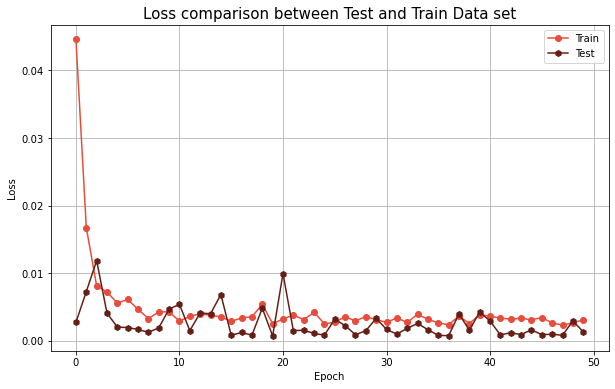

In [39]:
plt.figure(figsize=(10,6))
plt.plot(history2.history['loss'],color="#E74C3C",marker='o')
plt.plot(history2.history['val_loss'],color='#641E16',marker='h')
plt.title('Loss comparison between Test and Train Data set',fontsize=15)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)
plt.show()

In [40]:
train_pred2=model2.predict(x_train)
print(len(train_pred2))

13/13 [==============================] - 1s 5ms/step
390


In [41]:
test_pred2=model2.predict(x_test)
print(len(test_pred2))

2/2 [==============================] - 0s 5ms/step
61


In [42]:
# Remettre à l'echelle les variables pour les graphiques
train_pred2=scaler.inverse_transform(train_pred2)
# y_train_rescaled=scaler.inverse_transform(train)
test_pred2=scaler.inverse_transform(test_pred2)
# y_test_rescaled=scaler.inverse_transform(test)

In [43]:
trainScore=model2.evaluate(x_train,y_train,verbose=0)
print(trainScore)
testScore=model2.evaluate(x_test , y_test,verbose=0)
print(testScore)

0.0016513686859980226
0.001330666826106608


## **Vizualize predicted test**

In [44]:
test_pred_plot2=np.empty_like(y_test_rescaled)
test_pred_plot2[:]=np.nan
test_pred_plot2[TIME_STEPS:]=test_pred2

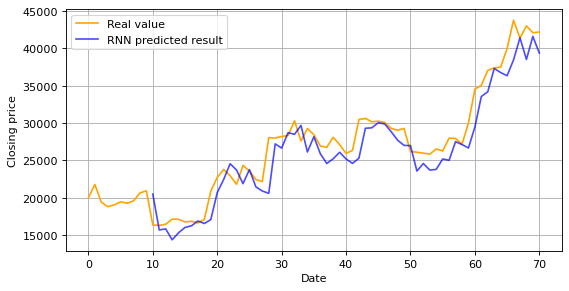

In [45]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_test_rescaled,color="orange",label="Real value")
plt.plot(test_pred_plot2,color="blue",alpha=0.7,label="RNN predicted result")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.grid(True)
plt.show()

## **Vizualize predicted train**

In [46]:
train_pred_plot2=np.empty_like(y_train_rescaled)
train_pred_plot2[:]=np.nan
train_pred_plot2[TIME_STEPS:]=train_pred2

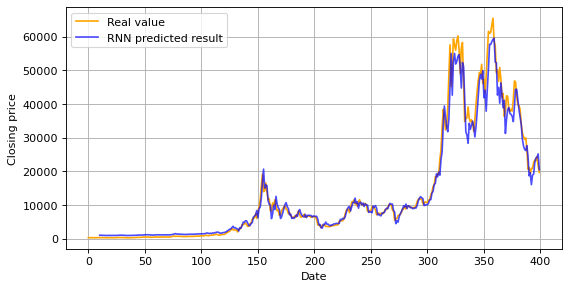

In [47]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_train_rescaled,color="orange",label="Real value")
plt.plot(train_pred_plot2,color="blue",alpha=0.7,label="RNN predicted result")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.grid(True)
plt.show()

## **Vizualizing overall predictions**

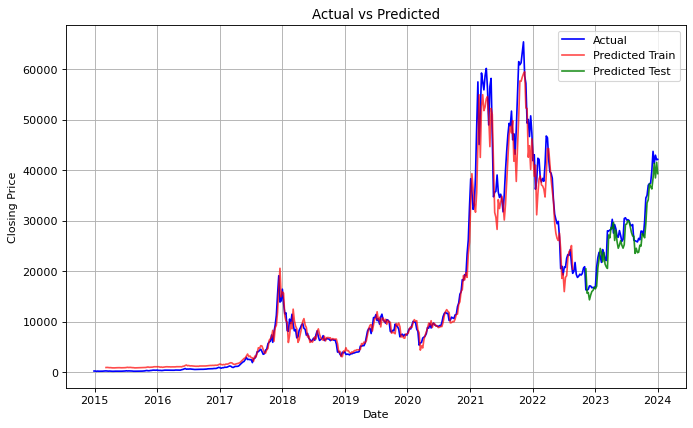

In [48]:
plot_predicted_vs_actual(Closing, train_pred2, test_pred2)

# **PART 2 : LSTM**

In [49]:
from keras.layers import  LSTM 

In [50]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [51]:
history3 = model.fit(x_train,y_train,verbose=1,epochs=NO_EPOCHS,batch_size=BATCH_SIZE,validation_data=(x_test,y_test))

Epoch 1/50
390/390 [==============================] - 7s 9ms/step - loss: 0.0384 - val_loss: 0.0015
Epoch 2/50
390/390 [==============================] - 3s 7ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 3/50
390/390 [==============================] - 2s 6ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 4/50
390/390 [==============================] - 2s 6ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 5/50
390/390 [==============================] - 4s 10ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/50
390/390 [==============================] - 3s 8ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/50
390/390 [==============================] - 4s 11ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 8/50
390/390 [==============================] - 4s 10ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 9/50
390/390 [==============================] - 2s 6ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 10/50
390/390 [==============================] - 3s 7ms/step - loss: 0.0018 - val_loss: 0.0

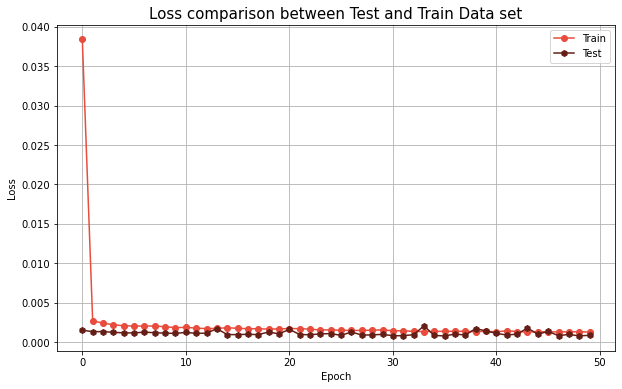

In [52]:
plt.figure(figsize=(10,6))
plt.plot(history3.history['loss'],color="#E74C3C",marker='o')
plt.plot(history3.history['val_loss'],color='#641E16',marker='h')
plt.title('Loss comparison between Test and Train Data set',fontsize=15)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)
plt.show()

In [53]:
train_pred3=model.predict(x_train)
print(len(train_pred3))

13/13 [==============================] - 1s 7ms/step
390


In [54]:
test_pred3=model.predict(x_test)
print(len(test_pred3))

2/2 [==============================] - 0s 10ms/step
61


In [55]:
# Remettre à l'echelle les variables pour les graphiques
train_pred3=scaler.inverse_transform(train_pred3)
# y_train_rescaled=scaler.inverse_transform(train)
test_pred3=scaler.inverse_transform(test_pred3)
# y_test_rescaled=scaler.inverse_transform(test)

In [56]:
trainScore=model.evaluate(x_train,y_train,verbose=0)
print(trainScore)
testScore=model.evaluate(x_test , y_test,verbose=0)
print(testScore)

0.0012542855693027377
0.0008772852597758174


In [57]:
test_pred_plot3=np.empty_like(y_test_rescaled)
test_pred_plot3[:]=np.nan
test_pred_plot3[TIME_STEPS:]=test_pred3

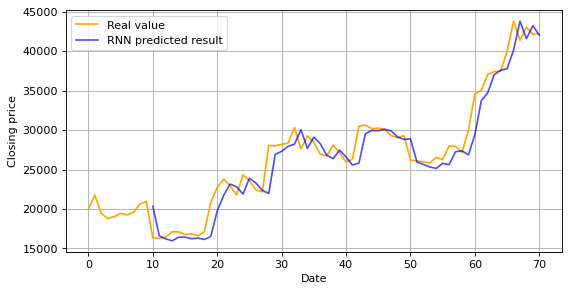

In [58]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_test_rescaled,color="orange",label="Real value")
plt.plot(test_pred_plot3,color="blue",alpha=0.7,label="RNN predicted result")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.grid(True)
plt.show()

In [59]:
train_pred_plot3=np.empty_like(y_train_rescaled)
train_pred_plot3[:]=np.nan
train_pred_plot3[TIME_STEPS:]=train_pred3

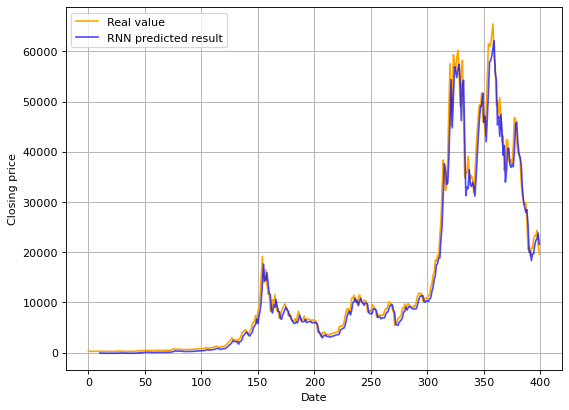

In [60]:
plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_train_rescaled,color="orange",label="Real value")
plt.plot(train_pred_plot3,color="blue",alpha=0.7,label="RNN predicted result")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.grid(True)
plt.show()

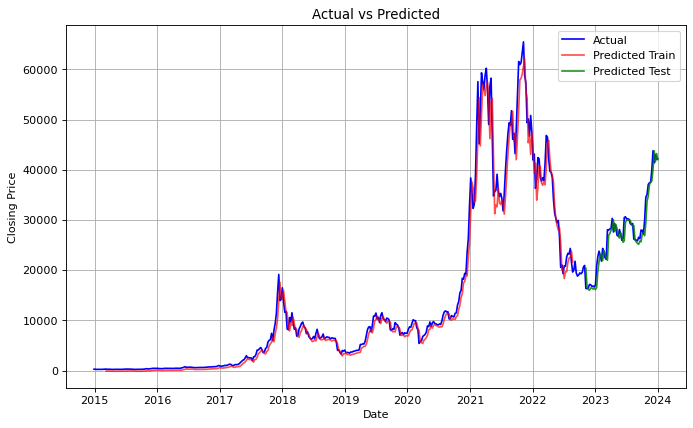

In [61]:
plot_predicted_vs_actual(Closing, train_pred3, test_pred3)

## **Comparing plots**

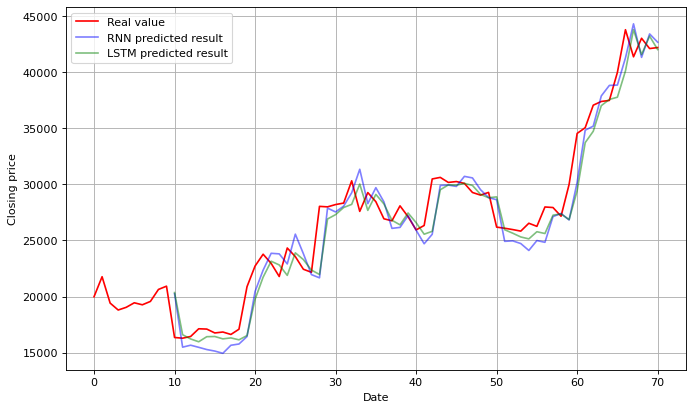

In [62]:
plt.figure(figsize=(10,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_test_rescaled,color="red",label="Real value")
plt.plot(test_pred_plot,color="blue",alpha=0.5,label="RNN predicted result")
plt.plot(test_pred_plot3,color="green",alpha=0.5,label="LSTM predicted result")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.grid(True)
plt.show()

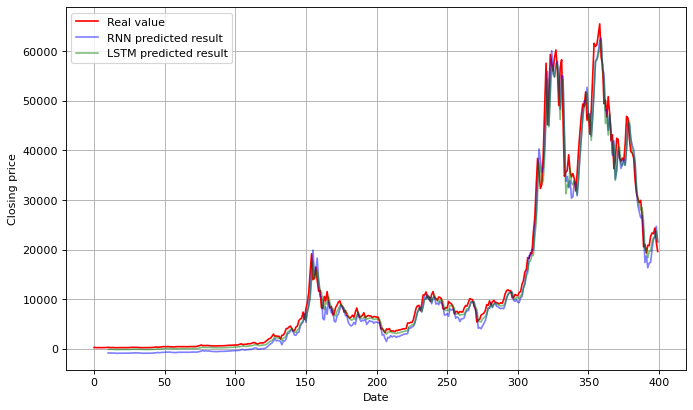

In [63]:
plt.figure(figsize=(10,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_train_rescaled,color="red",label="Real value")
plt.plot(train_pred_plot,color="blue",alpha=0.5,label="RNN predicted result")
plt.plot(train_pred_plot3,color="green",alpha=0.5,label="LSTM predicted result")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.grid(True)
plt.show()

## **Comparing MAE**

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

RNN1_mae = mean_absolute_error(y_test_rescaled[TIME_STEPS:], test_pred)
RNN2_mae = mean_absolute_error(y_test_rescaled[TIME_STEPS:], test_pred2)
LSTM_mae = mean_absolute_error(y_test_rescaled[TIME_STEPS:], test_pred3)



print("simple RNN Mean Absolute Error (MAE):", RNN1_mae)

print("RNN with dropout Mean Absolute Error (MAE):", RNN2_mae)

print("LSTM Mean Absolute Error (MAE):", LSTM_mae)


simple RNN Mean Absolute Error (MAE): 1564.7032050174178
RNN with dropout Mean Absolute Error (MAE): 1819.3942751721313
LSTM Mean Absolute Error (MAE): 1355.842245108607


## **Conclusion**

- For a time step = 10 both RNN and LSTM performed well. 
- When looking at plots they both understood the patterns.
- When we look at mae in overall the LSTM had the best score
- We can try a new expirement by changing the TIME_STEMP value with a bigger for example